<h1><center>Quality Of Supply And Happiness</center></h1>

### This document is a portfolio project of mine in which I clean, present and analyze data from World Happiness Survey as well as Quality of Electricity data available for European countries. I later merge the datasets and draw meaningful conclusions about people's tendencies to give biased answer while surveyed. 

The idea for this research project came from watching Thoughty2 video titled [The Happiest Country on Earth? Think Again...](https://youtu.be/tckVx_kaYco)

The thesis of the video is that the reason Scandinavian countries top the charts of world happiness rankings every year, is cultural. He recognizes that life in Scandinavia is good objectively, yet claims that the culture is such as to give them unfair advantage in all of the happiness rankings. [Exhibit A](https://en.wikipedia.org/wiki/World_Happiness_Report#2019_report)

He mentions The Law of Jante (Janteloven), according to Wikipedia it is a code of conduct known in Nordic countries that portrays not conforming, doing things out of the ordinary, or being overtly personally ambitious as unworthy and inappropriate

Basically Thoughty2's argument is, that culture in certain countries (going beyond just considering Scandinavian countries) may encourage people to report and feel happier about their life then they would otherwise be, given their circumstances in life. 

## The basic idea behind this portfolio project

It is impossible to measure happiness objectively. But for the sake of argument imagine that it were possible. In this case after surveying the people of a nation, and asking them how happy they think they are, it could be established how biased are they in their assessment of their own happiness (quality of their life). **The idea of this project is proving (or well presenting some evidence in favour) that these biases exist, that they are distinct from country to country and can be predicted.**

This is going to be done by finding biases for each of European nations concerning *something else* than their happiness (something measurable), and then comparing them to the unexplained happiness values. At the end of this project there was found a significant correlation between unexplained happiness values and bias values, which is interpreted as evidence for the existence and distinctiveness of the happiness biases. The *something else* in this case is quality of electricity in a country, and peoples biases concerning that.

*Note: bias in this context is used to describe a tendency of people to give an answer that is either overestimating or underestimating the true answer.*

## Data gathering and cleaning

I start out the analysis by importing all of the libraries that I'm gonna use

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import string
import pycountry
import warnings
import statsmodels.api as sm
import copy

The reason for choosing quality of electricity as the other source of data for the biases is that there is data available about **both** quality of electricity and perceived quality of electricity for each European country.

First dataset that I'm using was published by World Economic Forum (WEF) alongside their yearly ["The Global Competitiveness Report"](https://www.weforum.org/reports/global-competitiveness-report-2019). WEF gathers a lot of different statistical data from over 140 countries.
In fact the combined dataset with results from 2007 up to 2017, contains over 6000 different indeces for each of the countries

Below is the view of this dataset in excel

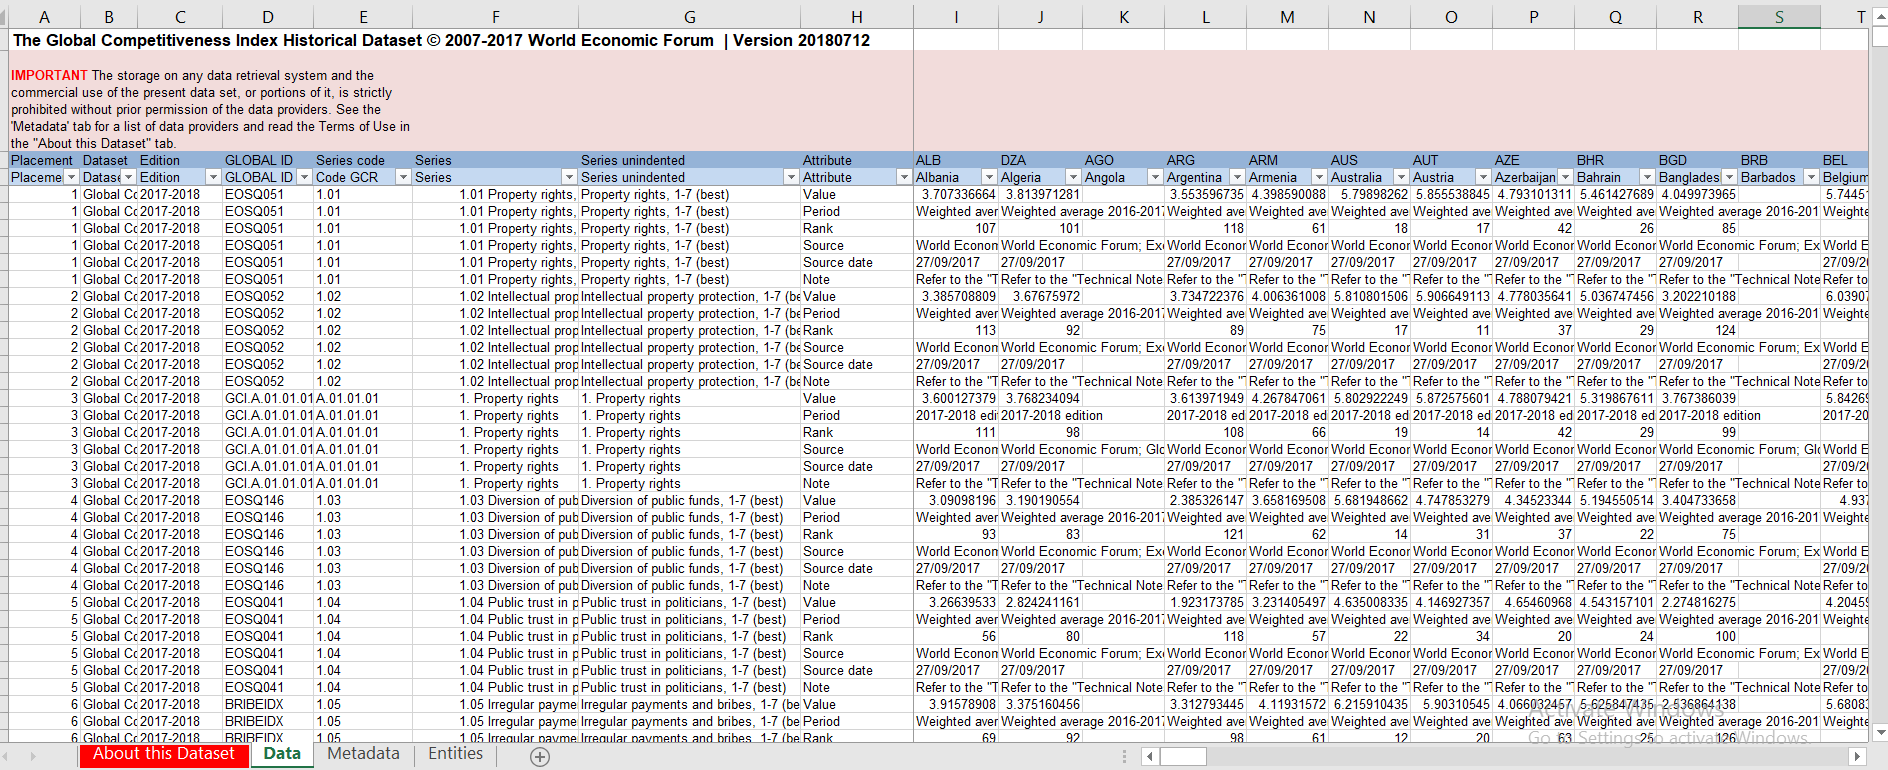

Specifically I'm interested in Executive Opinion Survey part of the dataset. This is a survey that is completed by business executives. More specifically I'm interested in one question that was asked:

<h2><center>In your country, how reliable is the electricity supply (lack of interruptions and lack of voltage fluctuations)? [1 = extremely unreliable; 7 = extremelyreliable]</center></h2>

After first filtering in excel and later cleaning the data in several ways in this notebook I create a final pandas DataFrame with clean data concerning answer to the question above. I call this dataframe **values_raw**

In [4]:
supply = pd.read_excel('supply_dataset.xlsx')

In [5]:
sup = supply.T
sup.drop(['Placement','GLOBAL ID','Code GCR','Series','Series unindented','Dataset'], inplace=True)

In [6]:
def value_cols(sup,cols):
    valuecols = []
    for col in cols:
        if sup[col].loc['Attribute'] == 'Value':
            valuecols.append(col)
    return valuecols

In [7]:
warnings.simplefilter('ignore')
values_raw = sup[value_cols(sup, sup.columns)]
values_raw.columns = values_raw.loc['Edition']
values_raw.drop(['Edition','Attribute'], axis = 0, inplace = True)
values_raw.drop(values_raw.tail(8).index, axis = 0,inplace = True)
values_raw.head()

Edition,2017-2018,2016-2017,2015-2016,2014-2015,2013-2014,2012-2013,2011-2012,2010-2011,2009-2010,2008-2009,2007-2008
Albania,4.60736,4.45015,4.72439,4.67217,4.45281,4.83051,4.98444,3.99643,2.71199,1.80472,1.65302
Algeria,4.19741,4.03566,4.02131,3.99995,4.18653,4.47241,4.59393,4.76944,4.39401,4.53281,4.50669
Angola,NaN,NaN,NaN,1.7145,1.65625,NaN,1.4185,1.53209,NaN,NaN,NaN
Argentina,3.00721,2.70286,2.56035,2.62633,3.05773,3.48083,3.75778,3.83035,3.48215,3.25399,3.6581
Armenia,4.78018,4.78378,4.76874,5.07773,5.20775,4.90274,4.76575,4.44769,4.22271,3.97428,3.86922


As can be noticed there is some amount of missing values in the dataset. In order to get some intuition about how many NULLs there are, and what can be done, I created visualization below (each yellow line correspolnds to a missing value)

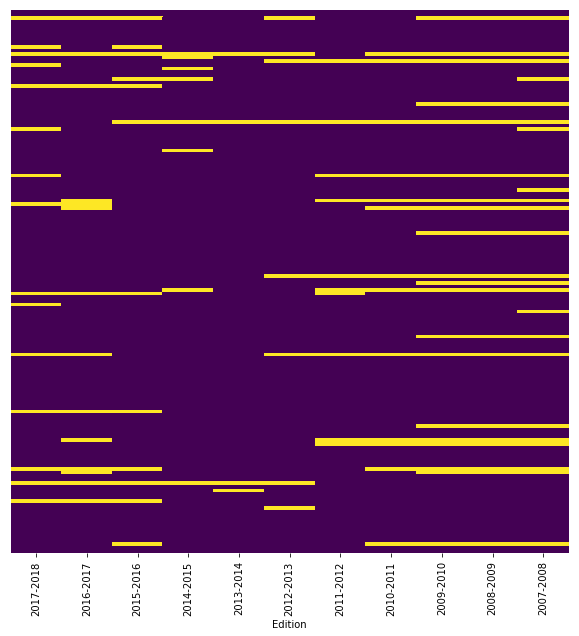

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(values_raw.isnull(),yticklabels=False, cbar=False, cmap='viridis')

As can be noticed in recent years the number of missing values is quite small. Even smaller for European countries, so  those missing values can be dropped

Below is a list of some of the top perceived quality of electricity (quality of supply) countries

In [9]:
ranking2018 = values_raw['2017-2018'].dropna().sort_values(ascending = False)
ranking2018.head(8)

Norway           6.86563
Switzerland      6.86451
Singapore        6.85355
Hong Kong SAR    6.84783
Denmark          6.78811
Netherlands       6.7796
France           6.76202
Luxembourg        6.7064
Name: 2017-2018, dtype: object

Next we're going to explore data that will show some factual statistics about quality supply. The data comes from Council of European Energy Regulators (CEER). In their [CEER Benchmarking Report 6.1 –Continuity of Electricity and Gas supply](https://www.ceer.eu/documents/104400/-/-/963153e6-2f42-78eb-22a4-06f1552dd34c) they gather several different quality of supply indexes per each country.

If the goal is to answer factually the question of: "*In your country, how reliable is the electricity supply?*", which index should be chosen? There is no one right answer. Based on my perception, the best one to be chosen is something called "planned and unplanned SAIDI, including exceptional events"

<h2><center>SAIDI - System Average Interruption Duration Inde, a measure of  how many minutes in a given year there's no electricity (per customer)</center></h2>

There are several subjective choices that I had to make. In my opinion weather interruption is planned, unplanned or is a result of some natural disaster, is all the same to a customer. There's no electricity. And so this index has been chosen

Next after a bit of processing (the actual csv files had to be extracted from a pdf version of report) the data about SAIDI for european countries for years 2002 - 2016 are stored in a variable **saidi_including** (since it includes exceptional events)

In [10]:
def dot_float_series(series):
    return pd.Series([float(element.replace('.','').replace(',','.'))if 
                      (type(element)== str and element[0] not in string.ascii_letters) else element for element in series])

In [11]:
saidi_including = pd.read_csv('saidi_including_ex_tabula.csv')
saidi_including = saidi_including.apply(dot_float_series, axis = 0)
saidi_including = saidi_including.set_index('Country')

After several more procedures (like cleaning, merging, dropping NULL values, and creating a column marking Scandinavian countries) two dataframes for years 2015 and 2016 were created comparing data from the poll (Survey) (scale from 1 to 7) and the actual, factual one (data in minutes). I called them **df_compare15** and **df_compare16**

In [12]:
ranking2016 = values_raw['2015-2016'].dropna().sort_values()

In [13]:
saidi2016 = saidi_including['2016']

In [14]:
ranking2015 = values_raw['2014-2015'].dropna().sort_values()
saidi2015 = saidi_including['2015']

In [15]:
df_compare16 = pd.concat([ranking2016, saidi2016], axis=1,sort=True)
df_compare16.columns = ['poll','saidi']
df_compare16 = df_compare16.dropna()

In [16]:
df_compare15 = pd.concat([ranking2015, saidi2015], axis=1, sort= True)
df_compare15.columns = ['poll','saidi']
df_compare15 = df_compare15.dropna()

In [17]:
df_compare16['scandinavia'] = np.zeros(df_compare16.shape[0])
for ind in df_compare16.index:
    if ind in ['Finland','Iceland','Norway','Denmark','Sweden']:
        df_compare16.loc[ind,'scandinavia'] = 1

In [18]:
df_compare15['scandinavia'] = np.zeros(df_compare15.shape[0])
for ind in df_compare15.index:
    if ind in ['Finland','Iceland','Norway','Denmark','Sweden']:
        df_compare15.loc[ind,'scandinavia'] = 1

In [19]:
df_compare16

,poll,saidi,scandinavia
Austria,6.5798,54.86,0.0
Bulgaria,4.34192,291.30,0.0
Croatia,5.60578,412.24,0.0
Czech Republic,6.39604,258.29,0.0
Denmark,6.69314,19.38,1.0
Estonia,5.56043,222.23,0.0
Finland,6.6875,80.56,1.0
France,6.51279,70.50,0.0
Germany,6.3873,23.55,0.0
Greece,5.18769,244.00,0.0


In [20]:
sns.set_style('whitegrid')

Below is a scatterplot with perceived quality on axis y and intervention duration (saidi) on axis x. Two linear regressions are plotted, for Scandinavian countries (excluding Iceland) and for all the rest

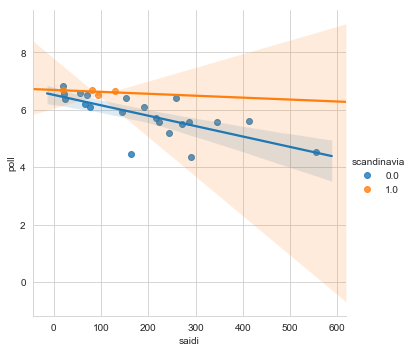

In [21]:
sns.lmplot(x = 'saidi', y = 'poll', data = df_compare16, hue = 'scandinavia')

For both Scandi and non-Scandi countries the higher is SAIDI the lower is percieved quality. The relationship seems to be quite linear, which is good news for linear modeling of the data

It can be noticd that in fact the linear approximation for Scandinavian countries is above that of non-Scandinavians, indicating that **it does look like Scandinavians are overly positive about how good is their electrical supply**

Let's do some more visualisatoins. This time I create linear model using **sci-kit learn**. This time there's one approximating line for all of the points.

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
x16 = df_compare16[['saidi']]
y16 = df_compare16['poll']

In [24]:
x15 = df_compare15[['saidi']]
y15 = df_compare15['poll']

In [25]:
lm16 = LinearRegression()

In [26]:
lm15 = LinearRegression()
lm15.fit(x15,y15)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
lm16.fit(x16,y16)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
lm16.coef_, lm16.intercept_
xline16 = np.linspace(0,600)

In [29]:
yline16 = lm16.intercept_ + lm16.coef_*xline16

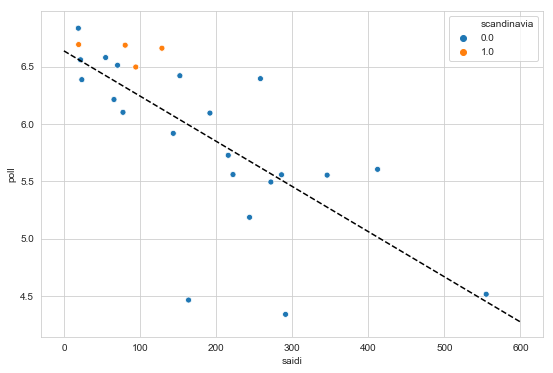

In [30]:
plt.figure(figsize=(9,6))
plt.plot(xline16, yline16, 'k--')
sns.scatterplot(y = 'poll',x = 'saidi', data = df_compare16, hue = 'scandinavia')

In [31]:
ypred16 = lm16.predict(df_compare16[['saidi']])
ypred15 = lm15.predict(df_compare15[['saidi']])

Now let's plot out how much each country is under/over estimating their el. supply quality according to the values predicted by the linear model

In [32]:
alpha2s = [pycountry.countries.get(name = country).alpha_2 if country != 'Czech Republic' else pycountry.countries.get(name = 'Czechia').alpha_2 for country in df_compare16.index[:]]

In [33]:
df_compare16_old_index = copy.deepcopy(df_compare16)

In [34]:
df_compare15_old_index = copy.deepcopy(df_compare15)

In [35]:
df_compare16.index = alpha2s

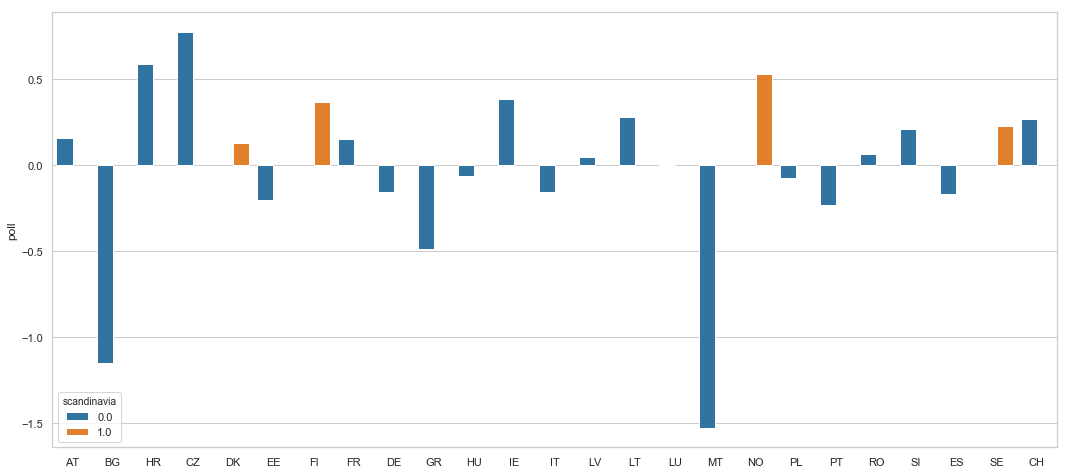

In [36]:
sns.set_context('notebook')
plt.figure(figsize = (18,8))
sns.barplot(x = df_compare16.index, y = df_compare16['poll'] - ypred16, hue = df_compare16['scandinavia'])

As can be seen all scandinavian countries are in the overestimator camp. The same happens while using data from years starting from 2012 up to 2016

Now here's the tricky part. At this point there's is no real reason to assume that deviations from the linear model (be it positive or negative) have anything to do with general tendencies of people in different countries to report biased values. For all we know these deviations are random, or for example are a result of different ways of measuring SAIDI (more on that on p. 10 of [this](https://www.ceer.eu/documents/104400/-/-/963153e6-2f42-78eb-22a4-06f1552dd34c) document)

To learn if there's in fact any good reason to asume that, let's consider World Happiness Report data

## [World Happiness Report](https://worldhappiness.report/)

This is a yearly survey. Thousands of people are surveyed.  **Respondents are asked to think of a ladder, with the best possible life for them being a 10, and the worst possible life being a 0. They are then asked to rate their own current lives on that 0 to 10 scale.**

Hear are first several rows of the 2015 survey

In [37]:
whr2015 = pd.read_csv('whr2015.csv')
whr2015.head(10)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
5,Finland,Western Europe,6,7.406,0.03140,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955
6,Netherlands,Western Europe,7,7.378,0.02799,1.32944,1.28017,0.89284,0.61576,0.31814,0.47610,2.46570
7,Sweden,Western Europe,8,7.364,0.03157,1.33171,1.28907,0.91087,0.65980,0.43844,0.36262,2.37119
8,New Zealand,Australia and New Zealand,9,7.286,0.03371,1.25018,1.31967,0.90837,0.63938,0.42922,0.47501,2.26425
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646


*Note: The "Dystopia Residual" is a result of machine learning model constructed by creators of WHR. In this model Happiness Score is being predicted by the rest of the 6 columns (Economy, Family, Health, Freedom, Trust, Generosity).
Dystopia is a hypothetical country with values of all for all 6 columns as low as the lowest values for any of the real countries. Dystopian happiness Score is around 1.9 (depending on a year). If this dystopian happiness score is added to the score predicted by the WHR model for each country there is still some residual happiness value. This values is a difference between predicted by the models happpiness score and actual happiness score. In World Happiness Report this value is called residual. This is a deviation that couldn't be predicted by the WHR model. Otherwise called unexplained happiness*

After more data manimupation a dataframe with columns signifying happiness and dystopian residuals for two years(2015 and 2016) was created and named **whr**

In [38]:
whr2016 = pd.read_csv('whr2016.csv')

In [39]:
whr = whr2015[['Country','Happiness Score', 'Dystopia Residual']].merge(right = whr2016[['Country','Happiness Score', 'Dystopia Residual']], on= 'Country')
whr.set_index('Country', inplace=True)
whr.columns = ['Score 2015','Dyst Res 2015', 'Score 2016','Dyst Res 2016']

In [40]:
# top (according to 2015 scores) 10 rows of the whr dataframe
whr.head(10)

,Score 2015,Dyst Res 2015,Score 2016,Dyst Res 2016
Country,,,,
Switzerland,7.587,2.51738,7.509,2.69463
Iceland,7.561,2.70201,7.501,2.83137
Denmark,7.527,2.49204,7.526,2.73939
Norway,7.522,2.46531,7.498,2.66465
Canada,7.427,2.45176,7.404,2.70485
Finland,7.406,2.61955,7.413,2.82596
Netherlands,7.378,2.46570,7.339,2.70749
Sweden,7.364,2.37119,7.291,2.54734
New Zealand,7.286,2.26425,7.334,2.47553


*Note: all of Scandinavian countries are near the top*

Next, residual is extracted from dystopian residual column by subtracting average value of it. After that, the biases that were extracted from analysis of quality of electricity are put in the dataframe together with residuals. These biases (from the barplot above) are presented in columns positivity 2015 and positivity 2016 of the dataframe **final_compare**

In [41]:
whr['residual 2015'] = whr['Dyst Res 2015'] - whr['Dyst Res 2015'].mean()

In [42]:
whr['residual 2016'] = whr['Dyst Res 2016'] - whr['Dyst Res 2016'].mean()

In [43]:
elpos16 = df_compare16_old_index['poll'] - ypred16
elpos15 = df_compare15_old_index['poll'] - ypred15

In [44]:
final_compare = whr[['residual 2015','residual 2016']]
final_compare = final_compare.merge(right=elpos15.to_frame(), left_index = True, right_index = True)
final_compare.rename(columns={'poll':'positivity 2015'}, inplace=True)

In [45]:
final_compare = final_compare.merge(right=elpos16.to_frame(), left_index = True, right_index = True)
final_compare.rename(columns={'poll':'positivity 2016'}, inplace=True)

In [46]:
final_compare = final_compare.merge(right=df_compare16_old_index['scandinavia'].to_frame(), left_index = True, right_index = True)

In [47]:
final_compare = final_compare.astype('float64')
final_compare

,residual 2015,residual 2016,positivity 2015,positivity 2016,scandinavia
Switzerland,0.438286,0.387632,0.187147,0.272308,0.0
Denmark,0.412946,0.432392,0.098548,0.131454,1.0
Norway,0.386216,0.357652,0.650719,0.530402,1.0
Finland,0.540456,0.518962,0.670901,0.366709,1.0
Sweden,0.292096,0.240342,0.109854,0.231067,1.0
Austria,0.454106,0.386432,0.196459,0.157820,0.0
Luxembourg,-0.109484,-0.196448,0.034089,0.008302,0.0
Ireland,-0.103394,-0.147118,0.359351,0.383515,0.0
Germany,0.036596,0.202312,-0.449898,-0.157963,0.0
France,0.132166,0.167402,0.059698,0.152389,0.0


Let's draw a scatterplot with residual and positivity on the two axis (for years 2015 and 2016)

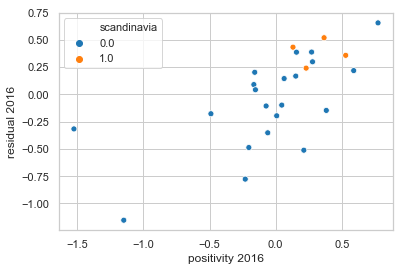

In [48]:
sns.scatterplot(y = final_compare['residual 2016'], x = final_compare['positivity 2016'], hue = final_compare['scandinavia'])

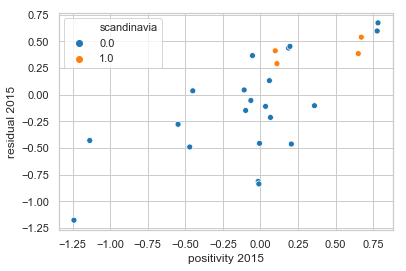

In [49]:
sns.scatterplot(y = final_compare['residual 2015'], x = final_compare['positivity 2015'], hue= final_compare['scandinavia'])

It can be clearly seen from these graphs that residual and positivity (from the quality of electricity analysis) are visibly correlated with each other.

In fact the correlation coefficients for data collected in years 2015 and 2016 is as following

In [50]:
corr2015 = final_compare['residual 2015'].corr(final_compare['positivity 2015'])
print ('correlation for year 2015 is around',str(int(corr2015*100)),'%')

correlation for year 2015 is around 68 %


In [51]:
corr2016 = final_compare['residual 2016'].corr(final_compare['positivity 2016'])
print ('correlation for year 2016 is around',str(int(corr2016*100)),'%')

correlation for year 2016 is around 66 %


Because these two questions (unexplained amount of happiness and positivity in estimating quality of electricity) have pretty much nothing to do with each other (so there shouldn't logically be any causal relationship between them), the conclusion to draw from high correlation of these two variables is that their changes are caused by some third independent variable. A logical candidate for this third variable is a general positivity. A general tendency to overestimate (or underestimate if it's negative) quality of things in peoples lives. If we assume that each country has some amount of this "positivity" then it could be included in the models to better predict Happiness Scores for each country.

To reiterate, the usefulness of including quality of electricity data into the analysis comes from the fact that WHR data on it's own doesn't provide any any insight into what is the cause of residual happiness. After introducing the quality of electricity data, high correlation above suggests that it is possible to explain part of the residual by assigning an abstract positivity term to every country. This will increase explanatory power of models that predict Happiness Scores.

Since based on the above analysis there is a good reason to believe that positivity of each country is influencing it's happiness score, the hypothesis put forth by Thoughty2 channel that cultural differences may have an effect on happiness rankings gained some additional support.

*Note: cultural explanation (positivity) is just one of the possible explanations for above correlation. Wording of questions in different languages and many other factors could be at play.*

The p value and t statistics describing association of positivity and residual for year 2015 are as following:

In [52]:
mod = sm.OLS(final_compare['residual 2015'],final_compare['positivity 2015'])
res = mod.fit()

In [53]:
print(res.pvalues)

positivity 2015    0.000109
dtype: float64


In [54]:
print (res.tvalues)

positivity 2015    4.621563
dtype: float64


## Conclusions

- There was presented evidence to support the hypothesis put forth by Thoughty2 that Scandinavian countries in particular are biased to give overly positive answers to quality of life surveys
- There was presented evidence regarding tendencies of countries' populations to respond to surveys about their life with a bias. This bias can be predicted based on survey answers to questions with factual answers.
- With further research there is a possibility to improve models predicting happiness scores by including this positivity bias
- Including additional estimates of general positivity bias for different countries can help estimate what part of residual (unexplained) happiness can be explained by it.